In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
## TO DO:

##Initialize price and other variables from API
##Calculate bollinger bands and moving averages
##Create buy and sell functions
##price = bianace.get_price('BTCUSDT')
from binance import Client, ThreadedWebsocketManager, ThreadedDepthCacheManager
import json
import datetime
from datamodel import Ticker, BollingerBand, PriceInterval

import math
from market_state_basic_test import MarketState

    
"""
Execution will using MarketState data to know when to execute a trade.
"""
import urllib.parse
import hashlib
import hmac
import base64
import requests
import time

class Execution():
    def __init__(self, client: Client = None, balance: int = 10000, open_orders: int = 0,  initial_order_value: int = 0):
        """"Formula is a tuple containing coins and their weights (ticker, weight)"""
        assert(client is not None)
        self.mstate = MarketState(client)
        self.open_orders = open_orders
        self.balance = balance
        self.initial_order_value = initial_order_value
        
    # get binanceus signature
    def get_binanceus_signature(self, data, secret):
        postdata = urllib.parse.urlencode(data)
        message = postdata.encode()
        byte_key = bytes(secret, 'UTF-8')
        mac = hmac.new(byte_key, message, hashlib.sha256).hexdigest()
        return mac
    

    # Attaches auth headers and returns results of a POST request
    def binanceus_request(self, uri_path, data, api_key, api_sec):
        # TODO: probably could just use the order API in the binance-python library
        headers = {}
        headers['X-MBX-APIKEY'] = api_key
        signature = self.get_binanceus_signature(data, api_sec)
        payload={
            **data,
            "signature": signature,
            }
        req = requests.post((self.api_url + uri_path),headers=headers,data=payload)
        return req.text
    

    #checks if the spread is above the upper bollinger band or below the lower bollinger band
    def place_order_condition(self, spread: float, upper_bollinger_band_price: float, lower_bollinger_band_price: float) -> bool:
        return spread >= upper_bollinger_band_price or spread <= lower_bollinger_band_price 

    #tell binance to buy at a certain price
    def place_limit_buy(self, symbol: str, quantity: float): 
        self.balance -= quantity * self.mstate.current_price(symbol)
        self.initial_order_value += quantity *  self.mstate.current_price(symbol)
        # print("Order placed: " + symbol + " at " + str(self.mstate.current_price(symbol)))
        # print("Balance: " + str(self.balance))
        self.open_orders +=1
    

    #tell binance to sell at a certain price
    def place_limit_sell(self, symbol: str, quantity: float):
        self.balance += quantity *  self.mstate.current_price(symbol)
        self.initial_order_value += quantity *  self.mstate.current_price(symbol)
        # print("Order placed: " + symbol + " at " +  str(self.mstate.current_price(symbol)))
        # print("Balance: " + str(self.balance))
        self.open_orders +=1
        
    def close_limit_buy(self, symbol: str, quantity: float):
        self.balance += quantity *  self.mstate.current_price(symbol)
        # print("Order closed: " + symbol + " at " +  str(self.mstate.current_price(symbol)))
        # print("Balance: " + str(self.balance))
        self.open_orders -=1
    
    def close_limit_sell(self, symbol: str, quantity: float):
        self.balance -= quantity *  self.mstate.current_price(symbol)
        # print("Order closed: " + symbol + " at " +  str(self.mstate.current_price(symbol))) 
        # print("Balance: " + str(self.balance))
        self.open_orders -=1

    #check if orders are still open or not before placing new orders
    def check_open_orders(self) -> bool:
        return self.open_orders > 0
        
    def current_positions_value(self, long_coin, short_coin, quantity_long, quantity_short) -> float:
        total_position_value = self.mstate.current_price(long_coin) * quantity_long + self.mstate.current_price(short_coin) * quantity_short
        # print("Current position value: " + str(total_position_value))
        return total_position_value


    #calculate time weighted take profit price for long position
    def take_profit_long_price(self, coin: str, timestamp, coin_pair: tuple[str, str]) -> float:
        decrease_rate = 0.055
        # target_price = self.mstate.spread_moving_avg(coin_pair) - (decrease_rate * timestamp) + self.mstate.derivative_of_spread(coin_pair) % self.mstate.current_price(coin) / 100
        target_price = self.mstate.spread_moving_avg(coin_pair)
        ## Need to add accelerator with the derivative of spread

        return target_price
    #calculate time weighted take profit price for short position
    def take_profit_short_price(self, coin: str, timestamp, coin_pair: tuple[str, str]) -> float:
        decrease_rate = 0.055
        # target_price = self.mstate.spread_moving_avg(coin_pair) + (decrease_rate * timestamp) + self.mstate.derivative_of_spread(coin_pair) % self.mstate.current_price(coin) / 100
        target_price = self.mstate.spread_moving_avg(coin_pair) 

        ## Need to add accelerator with the derivative of spread
        return target_price
    
    def plot_spread(self):
        return self.mstate.plot_spread()
    def plot_boll_bands(self):
        return self.mstate.plot_bollinger_bands()
    
    def main(self, long_coin: str, short_coin: str):
        # XXX: define quantity/fix params
        # TODO: making the function take in parameters allow us to test more easily and separately from MarketState (so we can isolate which class has a problem)
        # XXX: should return a result for each iteration of this (so we can debug/see what happened in each iteration during backtest)

        coin_pair = (long_coin, short_coin)
        self.mstate.track_spread_portfolio(coin_pair)
        
        beta = self.mstate.betas_dict[coin_pair][-1]
        balance = 10000
        
        quantity_long = 250 / self.mstate.current_price(long_coin)
        quantity_short = 250 * beta / self.mstate.current_price(short_coin)
        
        while self.mstate.row < len(self.mstate.coin_dfs[long_coin]):
        # Define all variables using MarketState
            self.mstate.update()
            # check if we should buy or sell
            if (self.place_order_condition(self.mstate.current_spread(coin_pair),
                                         self.mstate.spread_upper_bollinger_band(coin_pair),
                                         self.mstate.spread_lower_bollinger_band(coin_pair)) and not self.check_open_orders()):
                self.place_limit_buy(long_coin, quantity_long)
                self.place_limit_sell(short_coin, quantity_short)
                self.current_positions_value(long_coin, short_coin, quantity_long, quantity_short)
                #start timer
                timestamp = int(time.time() * 1000)

                # monitor when to sell
            if (self.check_open_orders()):
                #check if price is at or below hard stop loss
                if (-50 >= self.initial_order_value - self.current_positions_value(long_coin, short_coin, quantity_long, quantity_short)):
                    #sell at hard stop loss
                    self.close_limit_buy(long_coin, quantity_long)
                    self.close_limit_sell(short_coin, quantity_short)
                    continue
                #check if orders are at take profit price
                if (self.mstate.current_price(long_coin) >= self.take_profit_long_price(long_coin, timestamp, coin_pair) or self.mstate.current_price(short_coin) <= self.take_profit_short_price(short_coin, timestamp, coin_pair)):
                    self.close_limit_buy(long_coin, quantity_long)
                    self.close_limit_sell(short_coin, quantity_short)
                    continue

from exchange_setup import establish_connection
client = establish_connection(True)
execute = Execution(client)

pair_to_trade = ("FORTHUSD", "ZENUSD")
execute.main(*pair_to_trade)

import matplotlib.pyplot as plt
import numpy as np

spread = execute.plot_spread()
bband = execute.plot_boll_bands()

mean_values, stdev_values = zip(*bband[pair_to_trade])

upper_bound = [mean + 2 * stdev for mean, stdev in zip(mean_values, stdev_values)]
lower_bound = [mean - 2 * stdev for mean, stdev in zip(mean_values, stdev_values)]

# Plotting
plt.figure(figsize=(10, 6))

# Plot mean values
plt.plot(mean_values, label='Mean', marker='.')

plt.plot(spread[pair_to_trade], label='Spread', marker='.', linestyle='')
# Plot mean +- 2 * stdev
#only plot points, dont connect them 

plt.plot(upper_bound, label='Upper Bollinger', marker='.',  linestyle='')
plt.plot(lower_bound, label='Lower Bollinger', marker='.', linestyle='')

# Add labels and title
plt.xlabel('Data Point Index')
plt.ylabel('Values')
plt.title(f'Mean and Bollinger Bands for ({pair_to_trade[0]}, {pair_to_trade[1]})')
plt.legend()
plt.xlim(2000, len(mean_values))
plt.ylim(-0.00025, 0.00025)
# Show the plot
plt.show()


Dataframe: 
                       open    high     low  close      volume     close_time  \
timestamp                                                                       
2022-10-01 00:00:00  4.7100  4.7100  4.7100   4.71  0.00000000  1664582459999   
2022-10-01 00:01:00  4.7100  4.7100  4.7100   4.71  0.00000000  1664582519999   
2022-10-01 00:02:00  4.7100  4.7100  4.7100   4.71  0.00000000  1664582579999   
2022-10-01 00:03:00  4.7100  4.7100  4.7100   4.71  0.00000000  1664582639999   
2022-10-01 00:04:00  4.7100  4.7100  4.7100   4.71  0.00000000  1664582699999   
...                     ...     ...     ...    ...         ...            ...   
2022-10-14 23:56:00  4.0600  4.0600  4.0600   4.06  0.00000000  1665791819999   
2022-10-14 23:57:00  4.0600  4.0600  4.0600   4.06  0.00000000  1665791879999   
2022-10-14 23:58:00  4.0600  4.0600  4.0600   4.06  0.00000000  1665791939999   
2022-10-14 23:59:00  4.0600  4.0600  4.0600   4.06  0.00000000  1665791999999   
2022-10-15 00:00

IndexError: single positional indexer is out-of-bounds

In [41]:
import pandas as pd
spread_df = pd.DataFrame(list(spread[pair_to_trade]))
spread_df.describe()

,0
count,2.016000e+04
mean,2.937813e-09
std,1.664988e-05
min,-8.822530e-04
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,8.507637e-04


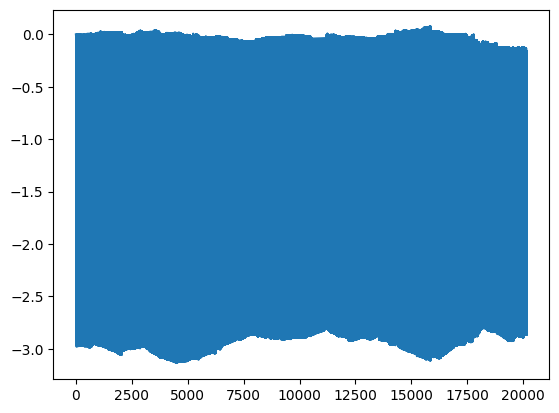

In [21]:
plt.plot(spread_df)

In [24]:
import numpy as np
spread_df
np.mean(spread_df)

-1.4872143697251345

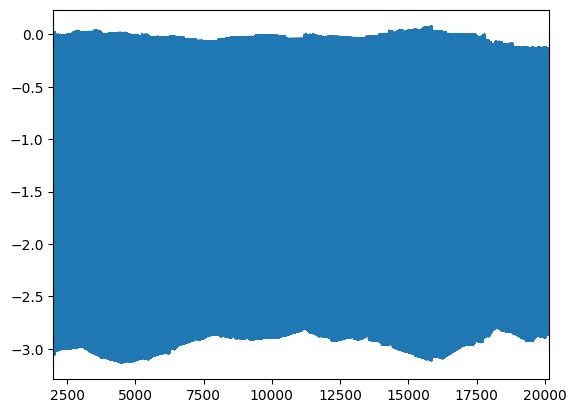

In [36]:
plt.xlim(2000, len(spread_df))
